In [ ]:
!pip install pathy -q
!pip install wandb -q

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image


In [ ]:
import requests
r = requests.get('https://ipinfo.io')
region = r.json()['region']
r.json()

{'city': 'Groningen',
 'country': 'NL',
 'hostname': '18.88.204.35.bc.googleusercontent.com',
 'ip': '35.204.88.18',
 'loc': '53.2192,6.5667',
 'org': 'AS15169 Google LLC',
 'postal': '9711',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Groningen',
 'timezone': 'Europe/Amsterdam'}

In [ ]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

parser.add_argument('-dim', '--d_model', default=256, type=int)
parser.add_argument('-nh', '--num_heads', default=4, type=int)
parser.add_argument('-nl', '--num_layers', default=6, type=int)
parser.add_argument('-sl', '--sequence_length', default=128, type=int)
parser.add_argument('-dr', '--dropout_rate', type=float, default=0.1)
parser.add_argument('-cl', '--grad_clip_value', type=float, default=0.25)
parser.add_argument('-ds', '--distributed', type=bool, default=False)


### Sample local config
args = parser.parse_args('''
dummy_run_rgb
--train_dataset train
--test_dataset test
-c
-s GCS
--bucket_name artificial_graphics
'''.split())


In [ ]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/artificial_graphics' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from Google Cloud Storage


Storage path: gs://artificial_graphics/


In [ ]:
!git pull
from importlib import reload
reload(lib)
# reload(lib.data)

Already up to date.


<module 'lib' (namespace)>

In [ ]:
import tensorflow_datasets as tfds
import lib
import lib.data

train_dl = lib.data.dataloader(TRAIN_DATA_PATHS, batch_size = 128, inception_prepro=True) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
train_dataset = iter(train_dl.dataset)
test_dl = lib.data.dataloader(TEST_DATA_PATHS, batch_size = 128, inception_prepro=True) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
test_dataset = iter(test_dl.dataset)

## Initialize InceptionV3 


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 6 # TODO Change
num_steps = 10000
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model



Model architecture inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* Extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* Squash that to a shape of (64, 2048).
* Vector passed through the CNN Encoder
* The RNN (here GRU) attends over the image to predict the next word. TODO: Convert to transformer

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, position_size=2, dimension_size=2, color_size=3):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.fc_position = tf.keras.layers.Dense(position_size)
    self.fc_dimension = tf.keras.layers.Dense(dimension_size)
    self.fc_color = tf.keras.layers.Dense(color_size)
    self.aux_size = position_size + dimension_size + color_size

    self.attention = BahdanauAttention(self.units)

  def call(self, prev_pred, prev_aux, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(prev_pred)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x, prev_aux], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    position = self.fc_position(x)
    dimensions = self.fc_dimension(x)
    color = self.fc_color(x)
    # output shape == (batch_size * max_length, vocab)
    pred = self.fc2(x)
    

    return pred, position, dimensions, color, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

mse = tf.keras.losses.MeanSquaredError()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')



def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
import wandb
wandb.init(project="artificial_graphics")
wandb.run.name = args.run_name
t = 0

wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


In [ ]:
checkpoint_path = str(STORAGE_PATH/f'saved_models/{args.run_name}')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:

if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training



In [ ]:
def accuracy(real, pred):
  
  padding = tf.cast(real != 0, tf.float32)
  pred = tf.cast(tf.squeeze(tf.random.categorical(pred, 1)), tf.int32)
  # print(padding*pred, padding)
  
  correct = tf.cast(real == pred, tf.float32)
  return tf.reduce_sum(correct*padding) / tf.reduce_sum(padding) # multiply by padding to 0 out anything which is a pad and then divide by it to get dividue by non pads e.g ./5


@tf.function
def train_step(data):
  class_loss = 0
  aux_loss = 0
  img_tensor, target = data['img'], data['target']
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([1] * target.shape[0], 1)
  aux_input  = tf.zeros([target.shape[0], 1, decoder.aux_size]) # B, Aux_size

  img_features = image_features_extract_model(img_tensor)
  img_features = tf.reshape(img_features, (img_features.shape[0], -1, img_features.shape[3]))

  metrics = {}
  with tf.GradientTape() as tape:
      features = encoder(img_features)

      for i in range(0, target.shape[1]):
          # passing the features through the decoder
          predictions, position, dimensions, color, hidden, _ = decoder(dec_input, aux_input, features, hidden)
          class_loss += loss_function(target[:, i], predictions)
          
          aux_loss += (mse(data['pos'][:,i], position) + mse(data['dimensions'][:,i], dimensions) + mse(data['color'][:,i], color))
          
          metrics[f"train_acc_step_{i}"] =  accuracy(target[:,i], predictions)
          
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          aux_input  = tf.concat([data['pos'][:,i], data['dimensions'][:,i], data['color'][:,i]], -1)[:,tf.newaxis,:] # B, Aux_size
          
      loss = class_loss+aux_loss


  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))


  metrics['train_class_loss'] =  class_loss / int(target.shape[1])
  metrics['train_aux_loss'] =  aux_loss / int(target.shape[1])


  return metrics

@tf.function
def step(data):
  class_loss = 0
  aux_loss = 0
  img_tensor, target = data['img'], data['target']
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([1] * target.shape[0], 1)
  aux_input  = tf.zeros([target.shape[0], 1, decoder.aux_size]) # B, Aux_size

  img_features = image_features_extract_model(img_tensor)
  img_features = tf.reshape(img_features, (img_features.shape[0], -1, img_features.shape[3]))


  features = encoder(img_features)
  metrics = {}
  for i in range(0, target.shape[1]):
      # passing the features through the decoder
      predictions, position, dimensions, color, hidden, _ = decoder(dec_input, aux_input, features, hidden)
      class_loss += loss_function(target[:, i], predictions)
      
      aux_loss += (mse(data['pos'][:,i], position) + mse(data['dimensions'][:,i], dimensions) + mse(data['color'][:,i], color))
      
      metrics[f"test_acc_step_{i}"] =  accuracy(target[:,i], predictions)
      
      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)
      aux_input  = tf.concat([data['pos'][:,i], data['dimensions'][:,i], data['color'][:,i]], -1)[:,tf.newaxis,:] # B, Aux_size


  metrics['test_class_loss'] =  class_loss / int(target.shape[1])
  metrics['test_aux_loss'] =  aux_loss / int(target.shape[1])
  return metrics


In [ ]:
# data = train_dataset.next()
# data.keys()
# metrics = train_step(data)

In [ ]:

while t < 3000:
    data = train_dataset.next()
    train_metrics = train_step(data)

    if t % 100 == 0:
        test_data = test_dataset.next()
        test_metrics = step(test_data)
        print(f'Batch {t} Loss {train_metrics["train_class_loss"]:.4f} Valid loss {test_metrics["test_class_loss"]:.4f}')
        wandb.log(train_metrics, step=t)
        wandb.log(test_metrics, step=t)
    if t % 1000 == 0:
      ckpt_manager.save()
    t += 1


Batch 1000 Loss 0.0007 Valid loss 0.0120
Batch 1100 Loss 0.0026 Valid loss 0.0020
Batch 1200 Loss 0.0014 Valid loss 0.0067
Batch 1300 Loss 0.0010 Valid loss 0.0320
Batch 1400 Loss 0.0118 Valid loss 0.0350
Batch 1500 Loss 0.0006 Valid loss 0.0014
Batch 1600 Loss 0.0013 Valid loss 0.0071
Batch 1700 Loss 0.0001 Valid loss 0.0001
Batch 1800 Loss 0.0001 Valid loss 0.0152
Batch 1900 Loss 0.0011 Valid loss 0.0151
Batch 2000 Loss 0.0001 Valid loss 0.0139
Batch 2100 Loss 0.0001 Valid loss 0.0002
Batch 2200 Loss 0.0003 Valid loss 0.0710
Batch 2300 Loss 0.0000 Valid loss 0.0122
Batch 2400 Loss 0.0000 Valid loss 0.0009
Batch 2500 Loss 0.0001 Valid loss 0.0002
Batch 2600 Loss 0.0001 Valid loss 0.0052
Batch 2700 Loss 0.0000 Valid loss 0.0004
Batch 2800 Loss 0.0001 Valid loss 0.0213
Batch 2900 Loss 0.0000 Valid loss 0.0145


## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
shapes = { 2: '<end>', 
      3: 'Rectangle',
       4: 'Chevron',
        5: 'Oval'}

In [ ]:
data = test_dataset.next()
max_length = data['target'].shape[1]
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([1], 0)
    aux_input  = tf.zeros([1, 1, decoder.aux_size]) # B, Aux_size
    result = []

    print("#############################################################")
    for i in range(max_length):
        predictions, position, dimensions, color, hidden, attention_weights = decoder(dec_input,aux_input,
                                                         features,
                                                         hidden)
        

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        print(f"{shapes[predicted_id]} xy: {position.numpy()}, dims: {dimensions.numpy()}, color: {color.numpy()}")
        result.append(shapes[predicted_id])

        if predicted_id == 2:
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
        aux_input  = tf.concat([position, dimensions, color], -1)[tf.newaxis,:] # B, Aux_size
        

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(img, result, attention_plot):
    temp_image = np.array(img)

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

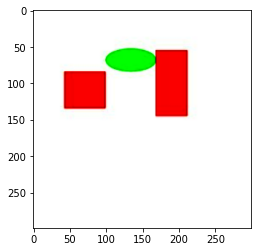

In [ ]:
data = test_dataset.next()
image = data['img'][0]
plt.imshow(image)

#############################################################
Rectangle xy: [[0.18648396 0.27042237]], dims: [[0.1868974  0.27647915]], color: [[1.0024825e+00 5.9279283e-03 7.3973183e-04]]
Oval xy: [[0.40564054 0.21832956]], dims: [[0.4073495  0.23040994]], color: [[0.15765555 0.74018496 0.10293642]]
Rectangle xy: [[0.74011546 0.16269661]], dims: [[0.7330251  0.16624735]], color: [[0.9146353  0.01547972 0.06234065]]
<end> xy: [[-0.0018371  -0.00206275]], dims: [[-0.0051395   0.00057941]], color: [[ 0.00313199 -0.00553162 -0.00714508]]
Prediction Caption: Rectangle Oval Rectangle <end>


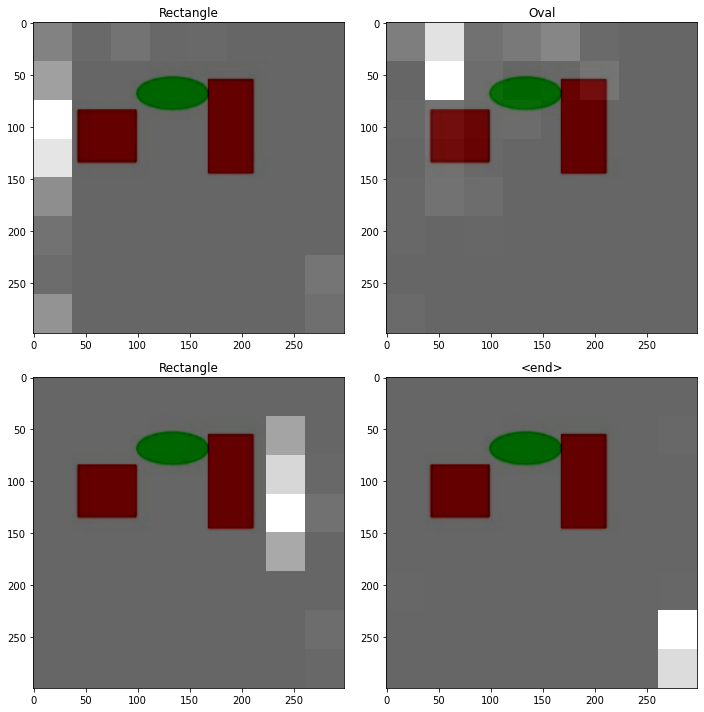

In [ ]:
# captions on the validation set

# real_caption = ' '.join([tokenizer.index_word[i]
#                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)